# Neural Network Quantum State



In [1]:
import os
import json

import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import ray
import netket as nk
import netket.nn as nn
import netket.experimental

from ray import tune
from ray.tune.suggest.hyperopt import HyperOptSearch
from IPython.display import display

from model import GCNN, FFN, setup_j1j2_problem, setup_model, ray_train_loop, get_ground_state

In [2]:
os.environ["JAX_PLATFORM_NAME"] = "cpu" # or gpu
# os.environ["RAY_PICKLE_VERBOSE_DEBUG"] = "1" # RAY DEBUG
# os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"  # force gpu w/o right drivers

skip_training = False
print(f'{nk.utils.mpi.available=}')

# Force detecting GPU in WSL
ray.shutdown()
ray.init(num_gpus=1)

nk.utils.mpi.available=True


RayContext(dashboard_url='', python_version='3.9.12', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '172.29.193.41', 'raylet_ip_address': '172.29.193.41', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-05-26_07-30-12_008841_1566/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-05-26_07-30-12_008841_1566/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-05-26_07-30-12_008841_1566', 'metrics_export_port': 39371, 'gcs_address': '172.29.193.41:61115', 'address': '172.29.193.41:61115', 'node_id': 'e72ca6924dd0bdd9387c747c89c44c817cfabc3756e84dec6fe56fca'})

### Hyperparameter tuning
Use this to select the best `hyperparameters`.

In [3]:
if not skip_training:
    
    search_space = {
        'model': {
            'alpha': tune.randint(1, 3+1), # last value exclusive
        },
        # 'activation': tune.choice(['tanh', 'sigmoid']),
        'learning_rate': tune.uniform(0.08, 0.12),
        'n_epochs': 300, #tune.qrandint(100, 300, 50),
        'n_samples': 1008, #tune.qrandint(100, 1000, 100),
    }
    
    metric = "energy_error"
    mode = "min"

    hyperopt_search = HyperOptSearch(metric=metric, mode=mode)
    hyper_band_scheduler = tune.schedulers.ASHAScheduler(
        metric=metric,
        mode=mode,
        max_t=search_space['n_epochs'].max_value if isinstance(search_space['n_epochs'], tune.sample.Sampler) else search_space['n_epochs'],
        grace_period=20
    )

    analysis = tune.run(
        tune.with_parameters(ray_train_loop, setup_problem=setup_j1j2_problem, model=FFN),
        config=search_space,
        progress_reporter=tune.JupyterNotebookReporter(True, [metric]),
        scheduler=hyper_band_scheduler,
        resources_per_trial={"cpu": 6, 'gpu': 1/2},
        search_alg=hyperopt_search,
        num_samples=2,
        resume='AUTO',
        # metric=metric,
        # mode=mode,
    )

Trial name,status,loc,learning_rate,model/alpha,n_epochs,n_samples,energy_error
ray_train_loop_4df408cc,RUNNING,172.29.207.112:13243,0.108655,3,300,1008,
ray_train_loop_6cf3af5c,RUNNING,172.29.207.112:13287,0.114438,3,300,1008,
ray_train_loop_6ebd0cb6,PENDING,,0.100219,3,300,1008,
ray_train_loop_35e4e2b0,TERMINATED,172.29.207.112:11817,0.0820474,3,300,1008,2.47154
ray_train_loop_37559518,TERMINATED,172.29.207.112:11853,0.114621,3,300,1008,2.83322
ray_train_loop_37576f46,TERMINATED,172.29.207.112:12472,0.0917719,1,300,1008,0.810342


  0%|          | 0/300 [00:03<?, ?it/s, Energy=-6.21-0.00j ± 0.28 [σ²=81.45, R̂=1.0083]]
2022-05-25 19:55:22,641	ERROR tune.py:697 -- Trials did not complete: [ray_train_loop_4df408cc, ray_train_loop_6cf3af5c, ray_train_loop_6ebd0cb6]
2022-05-25 19:55:22,641	INFO tune.py:701 -- Total run time: 110.00 seconds (105.39 seconds for the tuning loop).
2022-05-25 19:55:22,642	WARNING tune.py:707 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


### Select best model parameters

In [13]:
# TODO select best

H, hi, g, obs = setup_j1j2_problem(J2 = 0.8) #Remove the parameter for other models than j1j2. For j1j2 this chooses J2 when J1 = 1.0

hyperparams = {
    'model': {
        # 'alpha': 2
        'symmetries': g,
        'layers': 1,
        'features': 4
    },
    'learning_rate': 0.08,
    'n_epochs': 30,
    'n_samples': 1400,
}
file_name = 'best_params'

vstate, model, trainer = setup_model(H, hi, g, GCNN, hyperparams)

display(f'{vstate.n_parameters=}')

'vstate.n_parameters=84'

In [5]:
if not skip_training:
    log = nk.logging.JsonLog(file_name)  # save error per iteration in JSON
    #    trainer.run(n_iter=hyperparams['n_epochs'], out=log)
    trainer.run(n_iter=hyperparams['n_epochs'], out=log, obs=obs)
    # trainer.run(n_iter=hyperparams['n_epochs'], out=log)

    energy = vstate.expect(H)
    energy_analytic = get_ground_state(H)
    error = abs((energy.mean - energy_analytic) / energy_analytic)
    print("Optimized energy and relative error: ", energy, error)
    
    data = log.data

100%|██████████| 100/100 [03:27<00:00,  2.07s/it, Energy=2.560e+01+0.000e+00j ± nan [σ²=0.000e+00]]               


Optimized energy and relative error:  2.560e+01+0.000e+00j ± nan [σ²=0.000e+00] 1.756408840757111


Load trained model if `skip_training=True`

In [11]:
if skip_training:
    with open(f"{file_name}.log", encoding='utf8') as fp:
        data = json.load(fp)
    
    # Load `vstate`, i.e. |ket> from file
    vstate.variables = netket.experimental.vqs.variables_from_file(f"{file_name}.mpack", vstate.variables)

    energy_analytic = get_ground_state(H)

### Phase Diagram Loop

In [14]:
Nsim = 2
J2s = np.linspace(0.2, 0.8, num=Nsim)
Esim = np.zeros(Nsim)
Eacc = np.zeros(Nsim)
AFOPs = np.zeros(Nsim)
neelOPs = np.zeros(Nsim)
dimOPs = np.zeros(Nsim)
sigmas = np.zeros(Nsim)

hyperparams = {
    'model': {
        'alpha': 2
    },
    'learning_rate': 0.11,
    'n_epochs': 300,
    'n_samples': 1008,
}


for i, J2 in enumerate(J2s):
    H, hi, g, obs = setup_j1j2_problem(L=16, J2=J2) 
    vstate, model, trainer = setup_model(H, hi, g, FFN, hyperparams)
    log = nk.logging.RuntimeLog()
    
    trainer.run(n_iter=hyperparams['n_epochs'], out=log, obs=obs)
    data = log.data
    
    Eacc[i] = get_ground_state(H)
    neelOPs[i] = jnp.mean(jnp.real(data['Neel'].Mean)[-50:-1])
    AFOPs[i] = jnp.mean(jnp.real(data['AF'].Mean)[-50:-1])
    Esim[i] = jnp.mean(jnp.real(data['Energy'].Mean)[-50:-1])
    sigmas[i] = jnp.mean(jnp.real(data['Energy'].Sigma)[-50:-1])
    dimOPs[i] = jnp.mean(jnp.real(data['dimer'].Mean)[-50:-1])
    #abs((Esim[i] - Eacc[i]) / Eacc[i])


  5%|▍         | 14/300 [00:10<03:28,  1.37it/s, Energy=-26.277+0.009j ± 0.019 [σ²=0.373, R̂=1.0112]]

In [6]:
#save the results of above simualtion to file
# res_concat = np.concatenate((J2s,Esim,Eacc,AFOPs,neelOPs,sigmas,dimOPs)).reshape((-1, 7), order='F')
#np.save("data/J1J2_L20_1layer_withdimer.npy",res_concat)

NameError: name 'J2s' is not defined

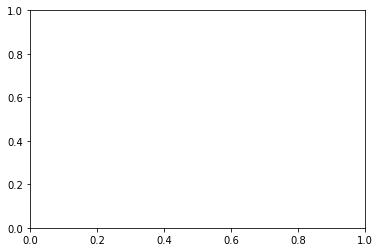

In [6]:
#plt.plot(J2s, Eacc)
#plt.plot(J2s, Esim)
#plt.plot(J2s, neels)

fig,ax = plt.subplots()
# make a plot
#ax.plot(J2s, Eacc, color="red")
l1 = ax.plot(J2s, Esim, color="red" ,label="$E_0$ NNQS")
l2 = ax.scatter(J2s, Eacc, color="red",marker ="o" ,s=80, facecolors='none',label="$E_0$ Exact")
ax.set_xlabel(r"$J_2/\,J_1$",fontsize=14)
ax.set_ylabel("Ground state energy $E_0$", color="red",fontsize=14)
ax.legend()

ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
l4 =ax2.plot(J2s, data['AF'], color="blue", label="AF OP")
l3 = ax2.plot(J2s, data['Neel'], '--', color="blue", label="Neel OP")
ax2.set_ylabel("Order Parameters", color="blue", fontsize=14)
ax2.legend(loc=(0.5, 0.1))

# save the plot as a file
#fig.savefig('Figures/.pdf',format='pdf',bbox_inches='tight')

## Results

/home/nikosavola/.local/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/nikosavola/.local/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Text(0, 0.5, 'Energy')

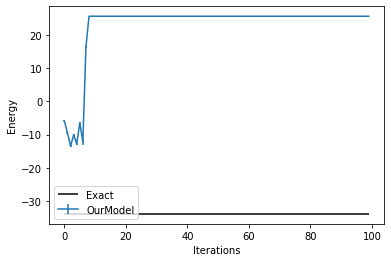

In [7]:
plt.errorbar(data["Energy"]["iters"], jnp.real(data["Energy"]["Mean"]), yerr=data["Energy"]['Sigma'], label="OurModel")
plt.hlines([energy_analytic], xmin=0, xmax=max(data["Energy"]["iters"]), color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

Text(0, 0.5, 'Energy')

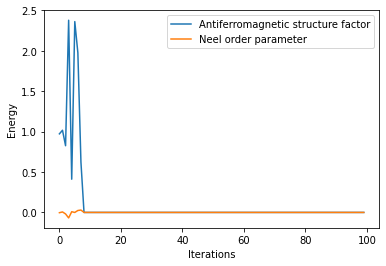

In [8]:
sf=data['sf']
neel=data['Neel']

plt.plot(data["Energy"].iters, jnp.real(sf.Mean),  label= "Antiferromagnetic structure factor")
plt.plot(data["Energy"].iters, jnp.real(neel.Mean),  label= "Neel order parameter")
#plt.hlines([E_gs_analytic], xmin=0, xmax=data["Energy"].iters.max(), color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')


### Wavefunctions

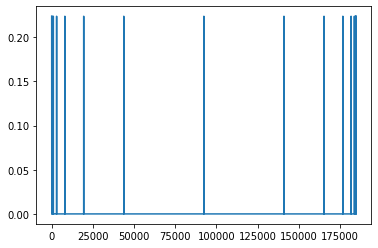

In [9]:
ket = vstate.to_array()

plt.plot(abs(ket))

# The AKLT Model

The AKLT model is an extension to the simple 1D Heisenberg spin model, proposed in 1987 by Affleck, I. et al.:

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.59.799

The model is essentially a 1D chain of spin-1/2 nuclei which form pairs. A constraint of having two spin-1/2 nuclei for each site is further imposed, which leads to the system being effectively a spin-1 system. This can be understood then to be a chain of these spin-1 "composite" nuclei. 

In the ground state of this Hamiltonian, every dimerized pair is referred to as a site and is given by a 

The AKLT Hamiltonian is given by a linear combination of the spin-1 projection operators in the respective Hilbert space $$\mathcal{H} \subset \mathbb{C}^3$$.